In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import userdata
token =userdata.get('Cryptonite-Token')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('/content/manipal_atmospherics_df - manipal_atmospherics_df.csv')

In [ ]:
df.describe()

,temperature_2m_mean (°C),precipitation_sum (mm),shortwave_radiation_sum (MJ/m²),apparent_temperature_mean (°C),wind_speed_10m_max (km/h),et0_fao_evapotranspiration (mm),sunshine_duration (s),wind_direction_10m_dominant (°),pressure_msl_mean (hPa),cloud_cover_mean (%),dew_point_2m_mean (°C),soil_moisture_0_to_7cm_mean (m³/m³)
count,5480.000000,5480.000000,5480.000000,5480.000000,5480.000000,5480.000000,5480.000000,5480.000000,5480.000000,5480.000000,5480.000000,5480.000000
mean,26.266715,9.319088,18.172217,30.421752,15.881314,3.874894,32432.841095,265.097080,1009.585657,63.644708,22.360255,0.385148
std,1.557200,16.782547,4.956198,2.302532,3.402819,1.203321,11448.653111,68.255966,1.876153,33.339070,2.276768,0.104756
min,22.700000,0.000000,1.900000,23.700000,5.900000,0.640000,0.000000,0.000000,999.100000,0.000000,10.600000,0.181000
25%,25.100000,0.000000,15.670000,28.800000,13.500000,3.090000,30436.440000,239.000000,1008.300000,33.000000,21.500000,0.269000
50%,26.000000,1.100000,19.420000,30.300000,15.700000,4.050000,37166.285000,284.000000,1009.600000,72.000000,23.100000,0.407000
75%,27.200000,11.600000,21.760000,31.900000,17.925000,4.790000,39066.010000,313.000000,1010.900000,96.000000,23.900000,0.488000
max,31.100000,169.700000,27.050000,37.000000,40.500000,6.610000,43200.000000,360.000000,1015.600000,100.000000,26.300000,0.516000


# Preprocessing

In [ ]:
date_time = pd.to_datetime(df.pop('time'), format='%Y-%m-%d')
df['day_of_year'] = date_time.dt.dayofyear
df['month'] = date_time.dt.month
df['year'] = date_time.dt.year

In [ ]:
def encode_cyclical(data, col, max_val):  #converting day of year and month into periodic signals
    data[col + '_sin'] = np.sin(2 * np.pi * data[col] / max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col] / max_val)
    return data

df = encode_cyclical(df, 'day_of_year', 365.25)
df = encode_cyclical(df, 'month', 12)

In [ ]:
wind_speed = df.pop('wind_speed_10m_max (km/h)')
wind_dir = df.pop('wind_direction_10m_dominant (°)')*np.pi*180 #converting into radians
df['wx'] = np.sin(wind_dir)*wind_speed
df['wy'] = np.cos(wind_dir)*wind_speed

In [ ]:
df_temp = df.copy()
df_prec = df.copy()

In [ ]:
df_temp['temp_roll_mean_7'] = df_temp['temperature_2m_mean (°C)'].rolling(window=7).mean()
df_temp['temp_roll_mean_30'] = df_temp['temperature_2m_mean (°C)'].rolling(window=30).mean()

df_temp.fillna(method='bfill', inplace=True)

/tmp/ipython-input-1637860821.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_temp.fillna(method='bfill', inplace=True)


In [ ]:
df_prec['prec_roll_mean_7'] = df_prec['precipitation_sum (mm)'].rolling(window=7).mean()
df_prec['prec_roll_mean_30'] = df_prec['precipitation_sum (mm)'].rolling(window=30).mean()
df_prec.fillna(method='bfill',inplace = True)

/tmp/ipython-input-2948925774.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_prec.fillna(method='bfill',inplace = True)


In [ ]:
test_start_date = '2024-12-05'
test_end_date = '2026-01-04'

test_mask = (date_time >= test_start_date) & (date_time <= test_end_date)
df_temp_test = df_temp[test_mask]
df_prec_test = df_prec[test_mask]

df_temp_train= df_temp[(date_time < '2023-01-01')]
df_prec_train = df_prec[(date_time < '2023-01-01')]

df_temp_val = df_temp[(date_time>='2023-01-01') & (date_time<'2024-12-05')]
df_prec_val = df_prec[(date_time>='2023-01-01') & (date_time<'2024-12-05')]

In [ ]:
df_temp_train.shape

(4380, 21)

In [ ]:
df_temp_val.shape

(704, 21)

In [ ]:
df_temp_test.shape

(396, 21)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler_temp = StandardScaler()
train_temp_scaled = scaler_temp.fit_transform(df_temp_train)  #creating dataset for temperature
val_temp_scaled = scaler_temp.transform(df_temp_val)
test_temp_scaled = scaler_temp.transform(df_temp_test)

In [ ]:
scaler_prec = StandardScaler()
train_prec_scaled = scaler_prec.fit_transform(df_prec_train)  #creating the dataset for precipitation
val_prec_scaled = scaler_prec.transform(df_prec_val)
test_prec_scaled = scaler_prec.transform(df_prec_test)

In [ ]:
import tensorflow as tf

In [ ]:
def create_dataset(data, target_col_idx, window_size, is_training=False):

  targets = data[window_size:, target_col_idx]

    # Create the dataset
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=targets,
      sequence_length=window_size,
      sequence_stride=1,
      sampling_rate=1,
      batch_size=32,
      shuffle=is_training,
      seed=42
    )

  return ds

# Baseline Model (Univariate)

In [ ]:
train_uni_temp_scaled = train_temp_scaled[:, 0] #fetching only the temp and prec column
val_uni_temp_scaled = val_temp_scaled[:, 0]
test_uni_temp_scaled = test_temp_scaled[:, 0]

train_uni_prec_scaled = train_prec_scaled[:, 1]
val_uni_prec_scaled = val_prec_scaled[:, 1]
test_uni_prec_scaled = test_prec_scaled[:, 1]

In [ ]:
train_uni_temp_ds = create_dataset(train_uni_temp_scaled.reshape(-1, 1), 0, 30, is_training=True)
val_uni_temp_ds   = create_dataset(val_uni_temp_scaled.reshape(-1, 1), 0, 30, is_training=False)
test_uni_temp_ds  = create_dataset(test_uni_temp_scaled.reshape(-1, 1), 0, 30, is_training=False)

train_uni_prec_ds = create_dataset(train_uni_prec_scaled.reshape(-1, 1), 0, 30, is_training=True)
val_uni_prec_ds   = create_dataset(val_uni_prec_scaled.reshape(-1, 1), 0, 30, is_training=False)
test_uni_prec_ds  = create_dataset(test_uni_prec_scaled.reshape(-1, 1), 0, 30, is_training=False)

In [ ]:
model_uni_rnn = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(64,activation='tanh',return_sequences=True),
    tf.keras.layers.Dense(1)
])

In [ ]:
model_uni_lstm = tf.keras.Sequential([
    tf.keras.layers.LSTM(64,activation='tanh',return_sequences=True),
    tf.keras.layers.Dense(1)
])

In [ ]:
model_uni_gru = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(64,activation='tanh',return_sequences=True),
    tf.keras.layers.Dense(1)
])

## Temperature Baseline

In [ ]:
optimizer_uni_rnn = tf.keras.optimizers.Adam(learning_rate=0.0001)
metrics = [tf.keras.metrics.RootMeanSquaredError(name='rmse'), 'mae']
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

In [ ]:
model_uni_rnn.compile(optimizer=optimizer_uni_rnn, loss='mse', metrics=metrics)
hist_uni1 = model_uni_rnn.fit(train_uni_temp_ds, epochs=100, validation_data=val_uni_temp_ds, callbacks=[early_stopping])

In [ ]:
model_uni_rnn.evaluate(test_uni_temp_ds)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 1.2459 - mae: 0.9240 - rmse: 1.0962


[1.096470832824707, 1.0471251010894775, 0.8503059148788452]

In [ ]:
optimizer_uni_lstm = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_uni_lstm.compile(optimizer=optimizer_uni_lstm, loss='mse', metrics=metrics)
hist_uni2 = model_uni_lstm.fit(train_uni_temp_ds, epochs=100, validation_data=val_uni_temp_ds, callbacks=[early_stopping])

In [ ]:
model_uni_lstm.evaluate(test_uni_temp_ds)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2841 - mae: 0.9376 - rmse: 1.1126


[1.1320433616638184, 1.063975214958191, 0.8643372654914856]

In [ ]:
optimizer_uni_gru = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_uni_gru.compile(optimizer=optimizer_uni_gru, loss='mse', metrics=metrics)
hist_uni3 = model_uni_gru.fit(train_uni_temp_ds, epochs=100, validation_data=val_uni_temp_ds, callbacks=[early_stopping])

In [ ]:
model_uni_gru.evaluate(test_uni_temp_ds)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.2517 - mae: 0.9259 - rmse: 1.0987


[1.1018950939178467, 1.0497119426727295, 0.8522983193397522]

In [ ]:
y_pred_uni_gru = model_uni_gru.predict(test_uni_prec_ds)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,root_mean_squared_error

In [ ]:
prediction_dates = date_time[test_mask].iloc[30:]
actual_temperatures = df_temp_test['temperature_2m_mean (°C)'].iloc[30:]

y_pred_uni_gru_temp = model_uni_gru.predict(test_uni_temp_ds)
dummy_array = np.zeros((y_pred_uni_gru_temp.shape[0], test_temp_scaled.shape[1]))
dummy_array[:, 0] = y_pred_uni_gru_temp[:, -1, 0]

denorm_y_pred_uni_gru = scaler_temp.inverse_transform(dummy_array)[:, 0]

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [ ]:
mean_absolute_error(denorm_y_pred_uni_gru,actual_temperatures)

1.285232404702698

In [ ]:
root_mean_squared_error(denorm_y_pred_uni_gru,actual_temperatures)

1.5842329274175362

## Precipitation Univariate

In [ ]:
model_uni_rnn.compile(optimizer=optimizer_uni_rnn, loss='mse', metrics=metrics)
hist_uni4 = model_uni_rnn.fit(train_uni_prec_ds, epochs=100, validation_data=val_uni_prec_ds, callbacks=[early_stopping])

In [ ]:
model_uni_rnn.evaluate(test_uni_prec_ds)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.6753 - mae: 0.7762 - rmse: 1.2070


[2.0362799167633057, 1.4269828796386719, 0.859307050704956]

In [ ]:
model_uni_lstm.compile(optimizer=optimizer_uni_lstm, loss='mse', metrics=metrics)
hist_uni5 = model_uni_lstm.fit(train_uni_prec_ds, epochs=100, validation_data=val_uni_prec_ds, callbacks=[early_stopping])

In [ ]:
model_uni_lstm.evaluate(test_uni_prec_ds)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.6718 - mae: 0.7784 - rmse: 1.2070


[2.0299112796783447, 1.4247496128082275, 0.8599627614021301]

In [ ]:
model_uni_gru.compile(optimizer=optimizer_uni_gru, loss='mse', metrics=metrics)
hist_uni6 = model_uni_gru.fit(train_uni_prec_ds, epochs=100, validation_data=val_uni_prec_ds, callbacks=[early_stopping])

In [ ]:
model_uni_gru.evaluate(test_uni_prec_ds)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.6793 - mae: 0.7800 - rmse: 1.2094


[2.0391316413879395, 1.4279816150665283, 0.8621061444282532]

In [ ]:
y_pred_uni_gru_prec = model_uni_gru.predict(test_uni_prec_ds)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


In [ ]:
prediction_dates = date_time[test_mask].iloc[30:]
actual_precipitation = df_prec_test['precipitation_sum (mm)'].iloc[30:]

y_pred_uni_gru_prec = model_uni_gru.predict(test_uni_prec_ds)
dummy_array = np.zeros((y_pred_uni_gru_temp.shape[0], test_prec_scaled.shape[1]))
dummy_array[:, 0] = y_pred_uni_gru_prec[:, -1, 0]

denorm_y_pred_uni_gru = scaler_temp.inverse_transform(dummy_array)[:, 0]

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [ ]:
mean_absolute_error(denorm_y_pred_uni_gru,actual_precipitation)

23.157837956460256

In [ ]:
root_mean_squared_error(denorm_y_pred_uni_gru,actual_precipitation)

26.29472007639083

# Multivariate Model

In [ ]:
train_temp_ds = create_dataset(train_temp_scaled, 0, 30,is_training=True)
val_temp_ds   = create_dataset(val_temp_scaled, 0, 30, is_training=False)
test_temp_ds  = create_dataset(test_temp_scaled, 0, 30, is_training=False)

In [ ]:
train_prec_ds = create_dataset(train_prec_scaled, 1, 30, is_training=True)
val_prec_ds   = create_dataset(val_prec_scaled, 1, 30, is_training=False)
test_prec_ds  = create_dataset(test_prec_scaled, 1, 30, is_training=False)

In [ ]:
for batch_X, batch_y in train_temp_ds.take(1):
  print(batch_X.shape)
  print(batch_y.shape)
  input_shape = batch_X.shape[1:]

(32, 30, 21)
(32,)


In [ ]:
model_rnn =  tf.keras.Sequential([
    tf.keras.Input(shape=input_shape),
    tf.keras.layers.SimpleRNN(64,activation='tanh',return_sequences=True),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.SimpleRNN(32,activation='tanh'),
    tf.keras.layers.Dense(1)
])

In [ ]:
model_lstm =  tf.keras.Sequential([
    tf.keras.Input(shape=input_shape),
    tf.keras.layers.LSTM(64,activation='tanh',return_sequences=True),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.LSTM(32,activation='tanh'),
    tf.keras.layers.Dense(1)
])

In [ ]:
model_gru =  tf.keras.Sequential([
    tf.keras.Input(shape=input_shape),
    tf.keras.layers.GRU(64,activation='tanh',return_sequences=True),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.GRU(32,activation='tanh'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1)
])

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
metrics = [tf.keras.metrics.RootMeanSquaredError(name='rmse'), 'mae']
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

## Temperature

In [ ]:
model_rnn.compile(optimizer=optimizer, loss='mse', metrics=metrics)
history1 = model_rnn.fit(train_temp_ds, epochs=100, validation_data=val_temp_ds, callbacks=[early_stopping])

Epoch 1/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 0.9912 - mae: 0.7899 - rmse: 0.9936 - val_loss: 0.3135 - val_mae: 0.4370 - val_rmse: 0.5599
Epoch 2/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.5654 - mae: 0.5986 - rmse: 0.7519 - val_loss: 0.2508 - val_mae: 0.3952 - val_rmse: 0.5008
Epoch 3/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.4376 - mae: 0.5250 - rmse: 0.6613 - val_loss: 0.2242 - val_mae: 0.3728 - val_rmse: 0.4735
Epoch 4/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.3833 - mae: 0.4918 - rmse: 0.6191 - val_loss: 0.2001 - val_mae: 0.3502 - val_rmse: 0.4473
Epoch 5/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.3253 - mae: 0.4537 - rmse: 0.5701 - val_loss: 0.1842 - val_mae: 0.3361 - val_rmse: 0.4291
Epoch 6/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.2940 - mae: 0.4276 - rmse: 0.5421 - val_loss: 0.1789 - val_mae: 0.3305 - val_rmse: 0.4229
Epoch 7/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2801 - mae: 

In [ ]:
model_rnn.evaluate(test_temp_ds)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.1310 - mae: 0.2699 - rmse: 0.3612


[0.13984793424606323, 0.37396249175071716, 0.2785227298736572]

In [ ]:
optimizer_lstm_temp = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_lstm.compile(optimizer=optimizer_lstm_temp, loss='mse', metrics=metrics)
history2 = model_lstm.fit(train_temp_ds, epochs=100, validation_data=val_temp_ds, callbacks=[early_stopping])

Epoch 1/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 1.0581 - mae: 0.8103 - rmse: 0.8987 - val_loss: 0.2839 - val_mae: 0.4314 - val_rmse: 0.5328
Epoch 2/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.2635 - mae: 0.4054 - rmse: 0.5133 - val_loss: 0.2384 - val_mae: 0.3951 - val_rmse: 0.4882
Epoch 3/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.2257 - mae: 0.3734 - rmse: 0.4751 - val_loss: 0.2173 - val_mae: 0.3770 - val_rmse: 0.4661
Epoch 4/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.2101 - mae: 0.3552 - rmse: 0.4583 - val_loss: 0.2148 - val_mae: 0.3737 - val_rmse: 0.4635
Epoch 5/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.1985 - mae: 0.3455 - rmse: 0.4454 - val_loss: 0.2040 - val_mae: 0.3624 - val_rmse: 0.4516
Epoch 6/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.1942 - mae: 0.3405 - rmse: 0.4406 - val_loss: 0.2009 - val_mae: 0.3576 - val_rmse: 0.4482
Epoch 7/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.1891 - mae: 

In [ ]:
model_lstm.evaluate(test_temp_ds)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2001 - mae: 0.3493 - rmse: 0.4459


[0.2024485319852829, 0.44994279742240906, 0.34836962819099426]

In [ ]:
optimizer_gru_temp = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_gru.compile(optimizer=optimizer_gru_temp, loss='mse', metrics=metrics)
history3 = model_gru.fit(train_temp_ds, epochs=100, validation_data=val_temp_ds, callbacks=[early_stopping])

Epoch 1/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.7566 - mae: 0.6850 - rmse: 0.7842 - val_loss: 0.2815 - val_mae: 0.4136 - val_rmse: 0.5306
Epoch 2/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.4083 - mae: 0.5047 - rmse: 0.6388 - val_loss: 0.2023 - val_mae: 0.3502 - val_rmse: 0.4498
Epoch 3/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.3443 - mae: 0.4605 - rmse: 0.5863 - val_loss: 0.1797 - val_mae: 0.3303 - val_rmse: 0.4239
Epoch 4/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.2923 - mae: 0.4253 - rmse: 0.5405 - val_loss: 0.1737 - val_mae: 0.3256 - val_rmse: 0.4167
Epoch 5/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.2783 - mae: 0.4168 - rmse: 0.5275 - val_loss: 0.1568 - val_mae: 0.3106 - val_rmse: 0.3960
Epoch 6/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.2613 - mae: 0.4044 - rmse: 0.5111 - val_loss: 0.1531 - val_mae: 0.3060 - val_rmse: 0.3913
Epoch 7/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.2485 - mae: 

In [ ]:
model_gru.evaluate(test_temp_ds)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1078 - mae: 0.2527 - rmse: 0.3274


[0.11931955814361572, 0.34542661905288696, 0.260170578956604]

In [ ]:
y_pred_gru = model_gru.predict(test_temp_ds)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


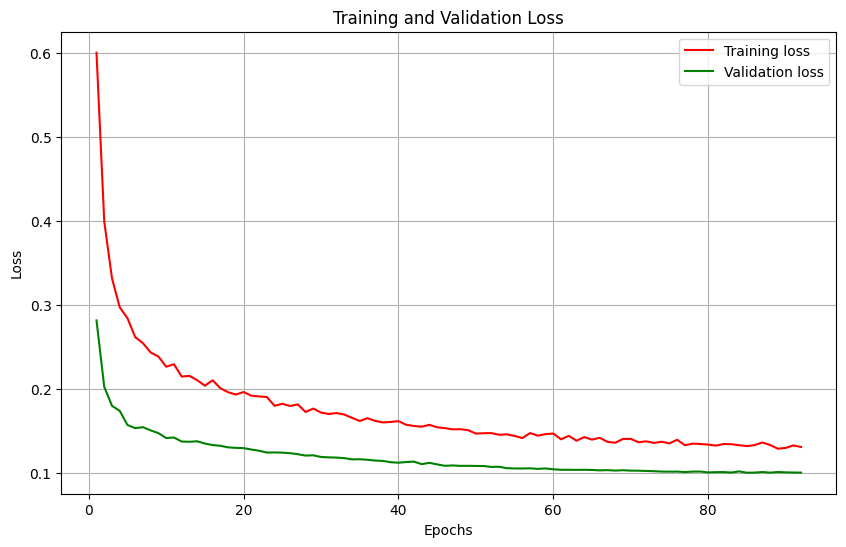

In [ ]:
train_loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.grid()
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [ ]:
prediction_dates = date_time[test_mask].iloc[30:]
actual_temperatures = df_temp_test['temperature_2m_mean (°C)'].iloc[30:]

dummy_array = np.zeros((y_pred_gru.shape[0], test_temp_scaled.shape[1]))
dummy_array[:, 0] = y_pred_gru.flatten()

denormalized_y_pred_gru = scaler_temp.inverse_transform(dummy_array)[:, 0]

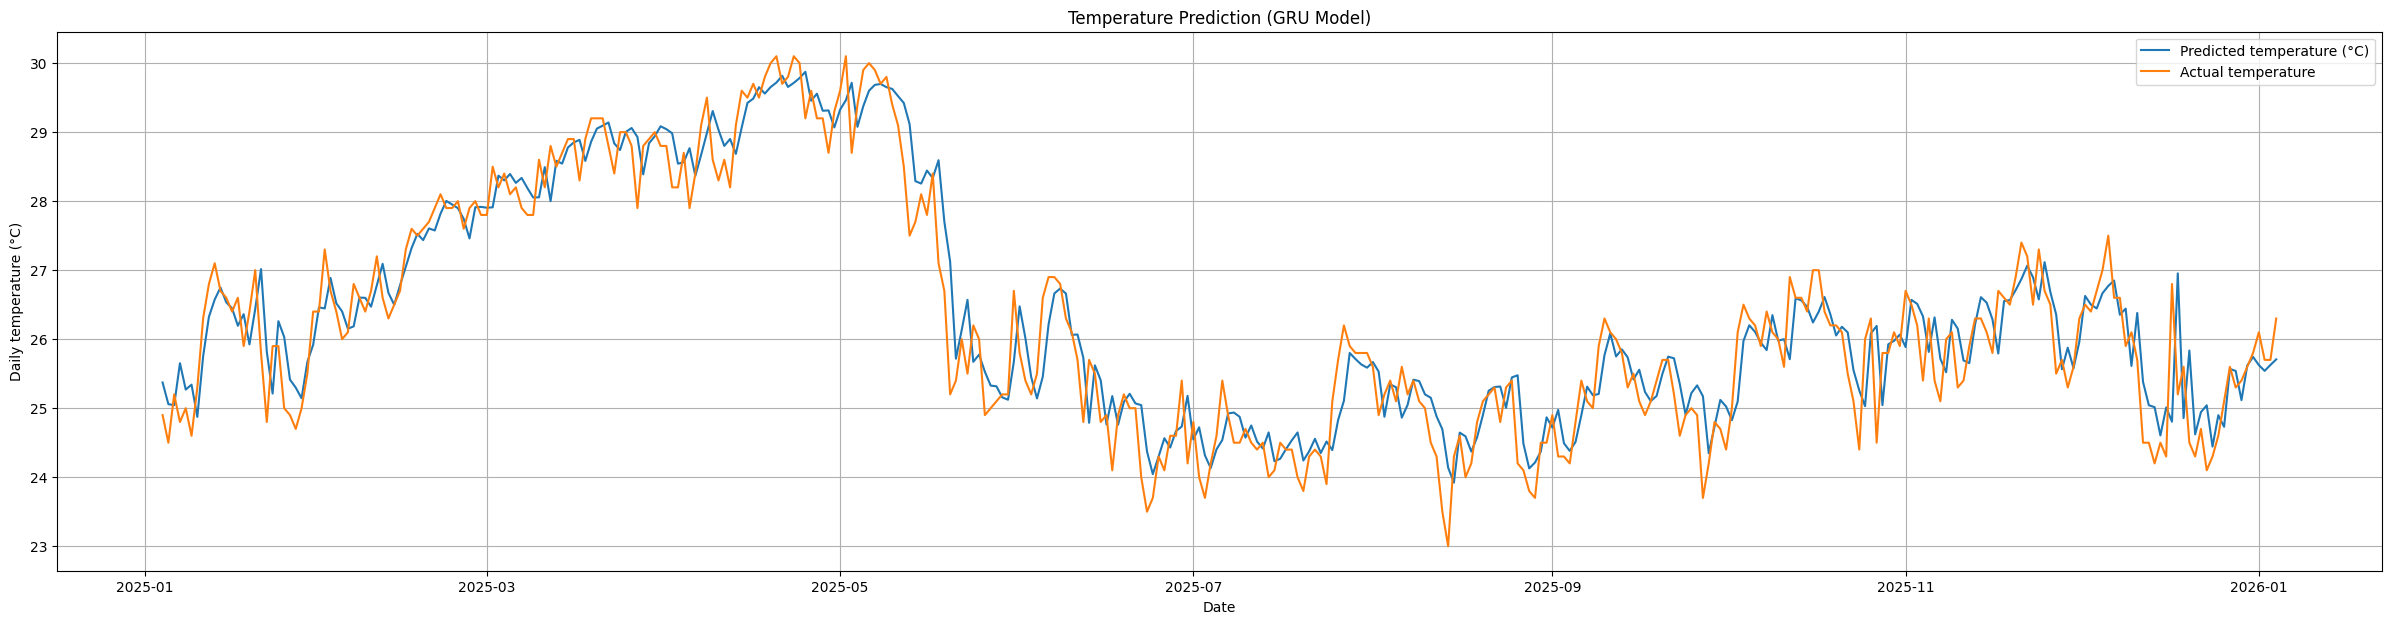

In [ ]:
plt.figure(figsize=(30, 7))
plt.plot(prediction_dates, denormalized_y_pred_gru, label='Predicted temperature (°C)')
plt.plot(prediction_dates, actual_temperatures, label='Actual temperature')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Daily temperature (°C)')
plt.title('Temperature Prediction (GRU Model)')
plt.grid(True)
plt.show()

In [ ]:
root_mean_squared_error(denormalized_y_pred_gru,actual_temperatures)

0.5292498555638994

In [ ]:
mean_absolute_error(denormalized_y_pred_gru,actual_temperatures)

0.39862363760332925

## Precipitation

In [ ]:
optimizer_rnn_prec = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_rnn.compile(optimizer=optimizer_rnn_prec, loss='mse', metrics=metrics)
history4 = model_rnn.fit(train_prec_ds, epochs=100, validation_data=val_prec_ds, callbacks=[early_stopping])

Epoch 1/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - loss: 1.4273 - mae: 0.8117 - rmse: 1.0473 - val_loss: 0.9315 - val_mae: 0.6031 - val_rmse: 0.9652
Epoch 2/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.7464 - mae: 0.5259 - rmse: 0.8627 - val_loss: 0.7977 - val_mae: 0.5287 - val_rmse: 0.8931
Epoch 3/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.6475 - mae: 0.4768 - rmse: 0.8035 - val_loss: 0.7343 - val_mae: 0.5014 - val_rmse: 0.8569
Epoch 4/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.6418 - mae: 0.4596 - rmse: 0.7977 - val_loss: 0.6904 - val_mae: 0.4844 - val_rmse: 0.8309
Epoch 5/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.5410 - mae: 0.4397 - rmse: 0.7344 - val_loss: 0.6603 - val_mae: 0.4678 - val_rmse: 0.8126
Epoch 6/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.5525 - mae: 0.4379 - rmse: 0.7429 - val_loss: 0.6382 - val_mae: 0.4597 - val_rmse: 0.7989
Epoch 7/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.5145 - mae: 

In [ ]:
model_rnn.evaluate(test_prec_ds)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.7528 - mae: 0.3556 - rmse: 0.7677


[0.9287644028663635, 0.9637242555618286, 0.44789132475852966]

In [ ]:
optimizer_lstm_prec = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_lstm.compile(optimizer=optimizer_lstm_prec, loss='mse', metrics=metrics)
history5 = model_lstm.fit(train_prec_ds, epochs=100, validation_data=val_prec_ds, callbacks=[early_stopping])

Epoch 1/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 1.4003 - mae: 0.7814 - rmse: 1.1089 - val_loss: 0.9351 - val_mae: 0.6171 - val_rmse: 0.9670
Epoch 2/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.7518 - mae: 0.5065 - rmse: 0.8664 - val_loss: 0.8271 - val_mae: 0.5203 - val_rmse: 0.9095
Epoch 3/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.6979 - mae: 0.4633 - rmse: 0.8323 - val_loss: 0.7800 - val_mae: 0.4854 - val_rmse: 0.8832
Epoch 4/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.6545 - mae: 0.4393 - rmse: 0.8065 - val_loss: 0.7527 - val_mae: 0.4665 - val_rmse: 0.8676
Epoch 5/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.6164 - mae: 0.4193 - rmse: 0.7814 - val_loss: 0.7214 - val_mae: 0.4606 - val_rmse: 0.8494
Epoch 6/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.5785 - mae: 0.4113 - rmse: 0.7589 - val_loss: 0.7212 - val_mae: 0.4513 - val_rmse: 0.8493
Epoch 7/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.5514 - mae: 

In [ ]:
model_lstm.evaluate(test_prec_ds)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9400 - mae: 0.3764 - rmse: 0.8381


[1.1692813634872437, 1.0813331604003906, 0.49565374851226807]

In [ ]:
optimizer_gru_prec = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_gru.compile(optimizer=optimizer_gru_prec, loss='mse', metrics=metrics)
history6 = model_gru.fit(train_prec_ds, epochs=100, validation_data=val_prec_ds, callbacks=[early_stopping])

Epoch 1/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 1.6780 - mae: 0.8811 - rmse: 1.2327 - val_loss: 0.9835 - val_mae: 0.6288 - val_rmse: 0.9917
Epoch 2/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.8593 - mae: 0.5727 - rmse: 0.9245 - val_loss: 0.8582 - val_mae: 0.5451 - val_rmse: 0.9264
Epoch 3/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.7473 - mae: 0.5224 - rmse: 0.8632 - val_loss: 0.7991 - val_mae: 0.5074 - val_rmse: 0.8939
Epoch 4/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.6823 - mae: 0.4819 - rmse: 0.8229 - val_loss: 0.7638 - val_mae: 0.4833 - val_rmse: 0.8740
Epoch 5/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.6704 - mae: 0.4710 - rmse: 0.8119 - val_loss: 0.7313 - val_mae: 0.4696 - val_rmse: 0.8551
Epoch 6/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.6173 - mae: 0.4484 - rmse: 0.7838 - val_loss: 0.7054 - val_mae: 0.4574 - val_rmse: 0.8399
Epoch 7/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.5934 - mae: 

In [ ]:
model_gru.evaluate(test_prec_ds)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7148 - mae: 0.3314 - rmse: 0.7368


[0.8854608535766602, 0.9409892559051514, 0.42556387186050415]

In [ ]:
y_pred_gru_prec = model_gru.predict(test_prec_ds)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


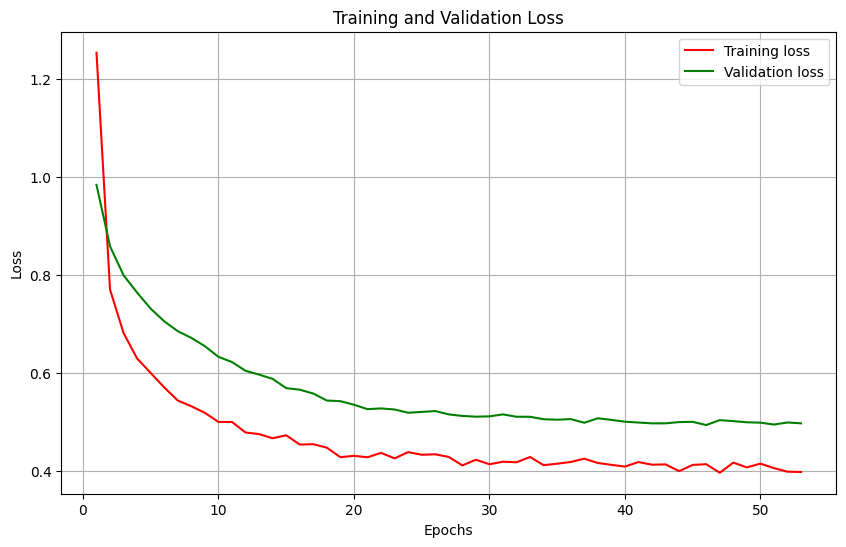

In [ ]:
train_loss = history6.history['loss']
val_loss = history6.history['val_loss']
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.grid()
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [ ]:
prediction_dates = date_time[test_mask].iloc[30:]
actual_precipitation = df_prec_test['precipitation_sum (mm)'].iloc[30:]

dummy_array = np.zeros((y_pred_gru_prec.shape[0], train_prec_scaled.shape[1]))
dummy_array[:, 1] = y_pred_gru_prec.flatten()

denormalized_y_pred_gru_prec = scaler_prec.inverse_transform(dummy_array)[:, 1]

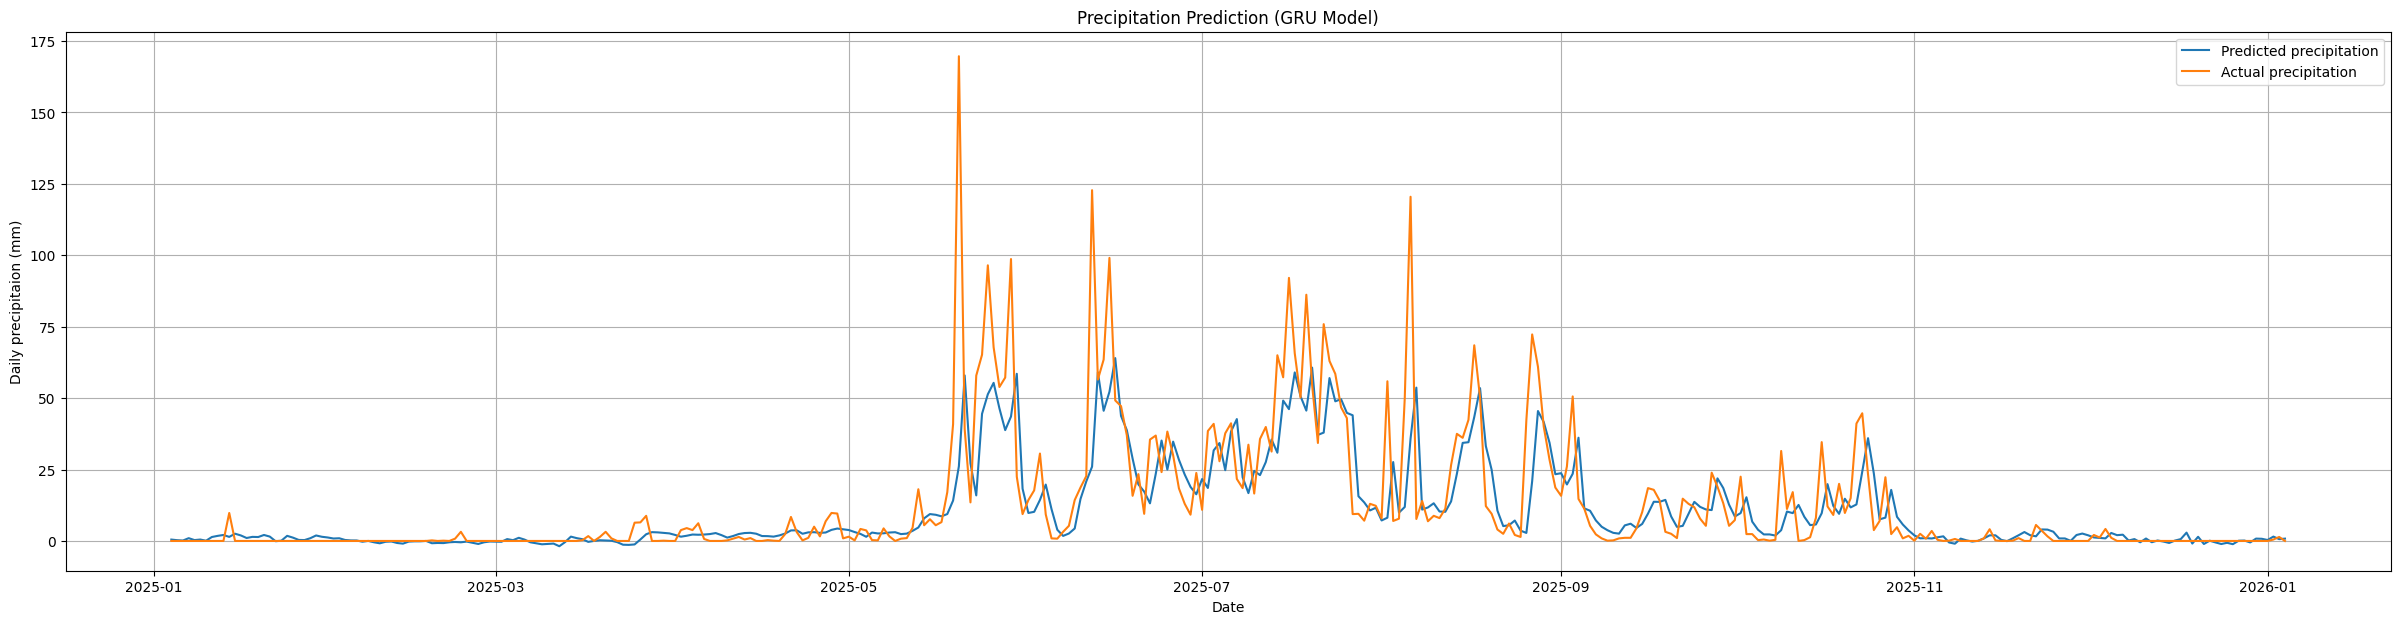

In [ ]:
plt.figure(figsize=(30, 7))

plt.plot(prediction_dates, denormalized_y_pred_gru_prec, label='Predicted precipitation')
plt.plot(prediction_dates, actual_precipitation, label='Actual precipitation')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Daily precipitaion (mm)')
plt.title('Precipitation Prediction (GRU Model)')
plt.grid(True)
plt.show()

In [ ]:
root_mean_squared_error(denormalized_y_pred_gru_prec,actual_precipitation)

15.049386012254626

In [ ]:
mean_absolute_error(denormalized_y_pred_gru_prec,actual_precipitation)

6.806108146174849